<a href="https://colab.research.google.com/github/bgtm/plane_classification/blob/main/notebooks/classificationSVM_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import data

In [ ]:
!curl -O https://www.robots.ox.ac.uk/~vgg/data/fgvc-aircraft/archives/fgvc-aircraft-2013b.tar.gz
!tar zxf fgvc-aircraft-2013b.tar.gz
! mv fgvc-aircraft-2013b dataset

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2625M  100 2625M    0     0  22.2M      0  0:01:57  0:01:57 --:--:-- 12.3M


# Library

In [1]:
#Original lib
import pathlib

# Data science lib (alpha)
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import tensorflow as tf
import seaborn as sns
import sklearn
import yaml


#from tensorflow.keras.utils import to_categorical
from PIL import Image
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

# Constants

In [32]:
with open(r'app.yaml') as file:
    doc = yaml.safe_load(file)
    print(doc)  

{'DATA_DIR': 'dataset/data', 'IMAGE_DEPTH': 3, 'IMAGE_WIDTH': 128, 'TARGET_NAME': 'manufacturer', 'MODELS_DIR': 'model'}


In [33]:
DATA_DIR = pathlib.Path(doc['DATA_DIR'])
IMAGE_WIDTH = doc['IMAGE_WIDTH']
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_DEPTH = doc['IMAGE_DEPTH']
TARGET_NAME = doc['TARGET_NAME']
MODELS_DIR = doc['MODELS_DIR']

# Functions

## Before training

In [4]:
def build_image_database(path, target) :
  """ Build pandas dataframe with target class and access path to images.

  Parameters
  -----------
  path (Path): path pattern to read csv file containing images information.
  target (str): Name of the target column


  Returns
  --------
  A pandas dataframe including target class and path to images.
  """
  _df=pd.read_csv(path,
              sep="\t", # Use a separator that do not exist to have a unique column as output
              names=['all'],
              dtype={'all': str} # Allows to keep the id begining with 00
              )
  
  #Extract the image_id
  _df['image_id']=_df['all'].apply(lambda x: x.split(' ')[0])
  # Extract the manufacturer name, using split, list reading and join
  _df[target]=_df['all'].apply(lambda x: ' '.join(x.split(' ')[1:]))

  _df['path'] = _df['image_id'].apply(lambda x: pathlib.Path('dataset/data/images') / (x+ ".jpg"))

  return _df.drop(columns=['all'])

In [5]:
def show_image (df,row,target) :
  """
  parameters
  ----------
  df (a dataframe) 
  row (numeric) : index of a row
  target (str) : what information to display (ex : manufacturer name)
  """
  assert target in df.columns, "Missing target colun in dataframe"
  assert 'path' in df.columns, "Missing image path in dataframe"
  
  print(df.iloc[row,][target])
  plt.imshow(plt.imread(df.iloc[row,]['path']))
  
  return 

In [6]:
def load_resize_image(path, height, width):
  """
  Load an image and resize it to the target size

  parameters
  ----------
  path (Path) : access path to image file
  height (int) : resize image to this height
  width (int) : resize image to this width

  Returns
  --------
  np.array containing resized image
  """
  # Use of Image from the PIL lib
  img_resize = np.array(Image.open(path).resize((width,height)))
  return img_resize.flatten()



In [7]:
def build_x_and_y (df : pd.DataFrame , target : str ,images : str ,stratify : str = None) :
  """
  Build x tensor and y tensor for model fitting

  Parameters
  ----------
  df (pd.DataFrame) : dataframe with target and images columns
  target (str) : column name for target variable
  images (str) : column name for images

  Return
  -------
  x (np.array) : tensor of X values
  y (np.array) : tensor of y values
  """
  x = np.array(df[images].to_list())
  y = df[target].astype('category').cat.codes
  
  return x,y

## After training

In [8]:
def classify_images(images, model,classes_names=None):
  """Classify images through a TF model.

  Parameters
  ----------
  images (np.array): set of images to classify
  model (tf.keras.Model): TF/Keras model
  classes_names : dictionary with names of classes

  Returns
  --------
  predicted classes
  """

  results = model.predict(images) # predict for images
  classes = np.argmax(results, axis=1) # np.argmax is computed row by row
  if classes_names is not None:
    classes = np.array(classes_names[classes])
  return classes



In [9]:
def save_model(model, basename):
  """Save tf/Keras model.

  Model file is named model + timestamp.

  Parameters
  ----------
  model (tf/Keras model): model to be saved
  basename: location to save model file
  """
  model.save('{}_{}.h5'.format(basename, datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')))
  return

# Train the model

In [10]:
# A faire une fois pour récupérer les informations sur la TPU
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Running on TPU  ['10.35.227.82:8470']
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.35.227.82:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.35.227.82:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [34]:
# Load train & test dataset
path_train = 'images_'+TARGET_NAME+'_train.txt'
path_test = 'images_'+TARGET_NAME+'_test.txt'

train_df = build_image_database(DATA_DIR / path_train,TARGET_NAME)
test_df = build_image_database(DATA_DIR / path_test,TARGET_NAME)

train_df['resize_image']=train_df.apply(lambda r: load_resize_image(r['path'],
                                                                    IMAGE_HEIGHT,IMAGE_WIDTH),
                                        axis=1)

test_df['resize_image']=test_df.apply(lambda r: load_resize_image(r['path'],
                                                                    IMAGE_HEIGHT,IMAGE_WIDTH),
                                      axis=1)

In [35]:
family_list=[]
count_list = []
init = train_df[TARGET_NAME].tolist()

for i in init:
  if (i in family_list) == False :
    family_list.append(i)
  if (i in family_list) == True :
    count_list.append(family_list.count(i))
    family_list.append(i)

In [39]:
train_df['duplicates'] = count_list
train = train_df[train_df['duplicates']<26]
train.shape

(750, 5)

In [40]:
# Split train&test
X_train, y_train = build_x_and_y(train, TARGET_NAME,'resize_image')
X_test, y_test = build_x_and_y(test_df, TARGET_NAME,'resize_image')

In [41]:
model = SVC(kernel = 'linear', random_state = 0, probability = True)

In [42]:
%time 
with tpu_strategy.scope():
  model.fit(X_train, y_train)

CPU times: user 0 ns, sys: 6 µs, total: 6 µs
Wall time: 13.1 µs


# Evaluate the model

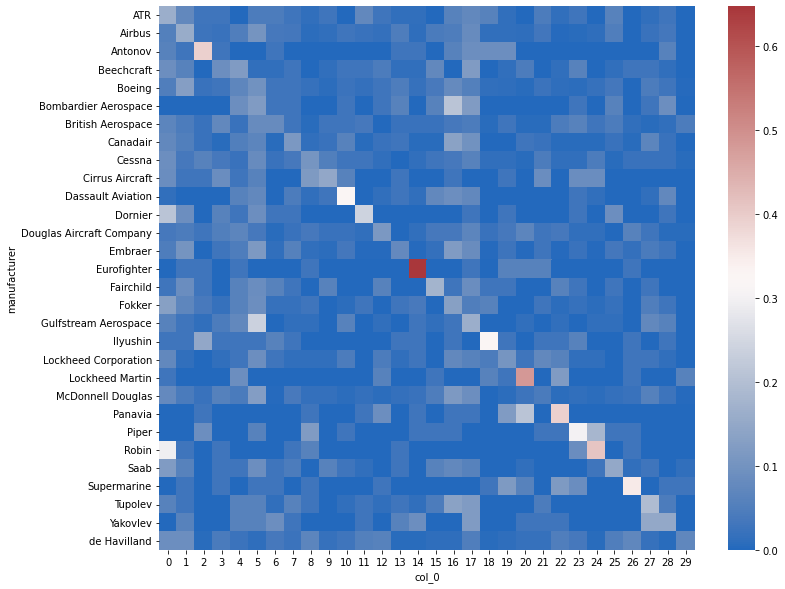

In [43]:
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(pd.crosstab(test_df[TARGET_NAME], 
                        model.predict(X_test), 
                        normalize='index'), cmap='vlag',ax=ax)

# Save the weights

In [28]:
! pip install pickle
import pickle

ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [44]:
# save the classifier
filename = TARGET_NAME + '.pkl'
pickle.dump(model, open(filename, 'wb'))

In [31]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.09030903090309031
